## Modeling

### Intro

**Problem**: Given a set of network traffic logs with features describing connection metadata and behavior, predict whether each connection instance represents a normal (benign) event or a malicious (attack) event — and ideally identify the type of attack.

### Setup

In [1]:
# Imports
import os
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

In [2]:
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
X_test = pd.read_csv('../data/processed/X_val.csv')
y_test = pd.read_csv('../data/processed/y_val.csv')
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (86167, 69)
y_train shape: (86167, 1)
X_test shape: (86189, 69)
y_test shape: (86189, 1)


### Modeling Setup

In [3]:
# Imports for Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier



In [ ]:
# Model training helpers
def _squeeze_y(y):
    return y.squeeze() if hasattr(y, "squeeze") else y

def train_logistic_regression(X_train, y_train, **kwargs):
    y = _squeeze_y(y_train)
    model = LogisticRegression(max_iter=1000, **kwargs)
    model.fit(X_train, y)
    return model

def train_random_forest(X_train, y_train, **kwargs):
    y = _squeeze_y(y_train)
    model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, **kwargs)
    model.fit(X_train, y)
    return model

def train_xgboost(X_train, y_train, **kwargs):
    y = _squeeze_y(y_train)
    model = XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="multi:softprob",
        eval_metric="mlogloss",
        random_state=42,
        **kwargs,
    )
    model.fit(X_train, y)
    return model

def train_gradient_boosting(X_train, y_train, **kwargs):
    y = _squeeze_y(y_train)
    model = GradientBoostingClassifier(random_state=42, **kwargs)
    model.fit(X_train, y)
    return model

def train_lightgbm(X_train, y_train, **kwargs):
    y = _squeeze_y(y_train)
    model = LGBMClassifier(
        n_estimators=300,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        verbosity=-1,
        **kwargs,
    )
    model.fit(X_train, y)
    return model

In [5]:
# Model evaluation helper
def evaluate_model(model, X_eval, y_eval, label=None):
    y_true = _squeeze_y(y_eval)
    y_pred = model.predict(X_eval)
    acc = accuracy_score(y_true, y_pred)
    title = f"Evaluation: {label}" if label else "Evaluation"
    print(title)
    print("Accuracy:", round(acc, 4))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification report:\n", classification_report(y_true, y_pred))
    return {
        "accuracy": acc,
        "confusion_matrix": confusion_matrix(y_true, y_pred),
        "classification_report": classification_report(y_true, y_pred, output_dict=True),
    }

In [6]:
# Grid search helper
def grid_search_model(model, param_grid, X_train, y_train, scoring="accuracy", cv=3, n_jobs=-1, verbose=1):
    y = _squeeze_y(y_train)
    search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose,
        refit=True,
    )
    search.fit(X_train, y)
    return {
        "best_estimator": search.best_estimator_,
        "best_params": search.best_params_,
        "best_score": search.best_score_,
        "search": search,
    }

### Param Selection

In [7]:
# Grid search spaces (more robust coverage across complexity/regularization settings)
rf_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "class_weight": [None, "balanced"],
}

lr_grid = [
    {
        "solver": ["lbfgs"],
        "penalty": ["l2"],
        "C": [0.01, 0.1, 1.0, 10.0, 100.0],
        "class_weight": [None, "balanced"],
    },
    {
        "solver": ["saga"],
        "penalty": ["l1", "l2"],
        "C": [0.01, 0.1, 1.0, 10.0],
        "class_weight": [None, "balanced"],
    },
]

xgb_grid = {
    "n_estimators": [200, 400],
    "max_depth": [4, 6],
    "learning_rate": [0.03, 0.05],
    "subsample": [0.7, 0.85],
    "colsample_bytree": [0.7, 0.85],
    "min_child_weight": [1, 3],
    "gamma": [0, 0.1],
}

gb_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.03, 0.05],
    "max_depth": [2, 3],
    "subsample": [0.8, 0.9],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

lgbm_grid = {
    "n_estimators": [200, 400],
    "learning_rate": [0.03, 0.05],
    "num_leaves": [31, 63],
    "max_depth": [-1, 10],
    "subsample": [0.7, 0.85],
    "colsample_bytree": [0.7, 0.85],
    "min_child_samples": [20, 40],
    "reg_alpha": [0.0, 0.1],
    "reg_lambda": [0.0, 0.1],
}

In [ ]:
# Choose which model to tune
model_name = "random_forest"  # options: random_forest, logistic, xgboost, gradient_boosting, lightgbm

models = {
    "random_forest": (RandomForestClassifier(random_state=42, n_jobs=-1), rf_grid),
    "logistic": (LogisticRegression(max_iter=2000), lr_grid),
    "xgboost": (XGBClassifier(objective="multi:softprob", eval_metric="mlogloss", random_state=42), xgb_grid),
    "gradient_boosting": (GradientBoostingClassifier(random_state=42), gb_grid),
    "lightgbm": (LGBMClassifier(random_state=42, n_jobs=-1, verbosity=-1), lgbm_grid),
}

model, grid = models[model_name]
result = grid_search_model(model, grid, X_train, y_train, scoring="f1_weighted", cv=5)
print("Best params:", result["best_params"])

best_model = result["best_estimator"]
evaluate_model(best_model, X_test, y_test, label=f"{model_name} (tuned)")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params: {'class_weight': 'balanced', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Evaluation: random_forest (tuned)
Accuracy: 0.9849
Confusion matrix:
 [[83219     3     0     6   101   402     6    28     6     0]
 [    5     1     0     0     5     0     0     0     0     0]
 [    4     0     2     1     3     2     0     0     0     0]
 [   18     0     0    15    80     3     4     8     0     0]
 [   68     0     1    18   714    15    17    52     4     0]
 [  220     0     1     5    37   542     1     4     0     0]
 [    8     0     0     9    40     4    70     0     1     1]
 [    0     0     0     3    57     4     1   303     0     0]
 [   26     0     0     1    14     0     0     0    19     0]
 [    0     0     0     0     7     0     0     0     0     0]]
Classification report:
               precision    recall  f1-score   support

     

{'accuracy': 0.9848704591073106,
 'confusion_matrix': array([[83219,     3,     0,     6,   101,   402,     6,    28,     6,
             0],
        [    5,     1,     0,     0,     5,     0,     0,     0,     0,
             0],
        [    4,     0,     2,     1,     3,     2,     0,     0,     0,
             0],
        [   18,     0,     0,    15,    80,     3,     4,     8,     0,
             0],
        [   68,     0,     1,    18,   714,    15,    17,    52,     4,
             0],
        [  220,     0,     1,     5,    37,   542,     1,     4,     0,
             0],
        [    8,     0,     0,     9,    40,     4,    70,     0,     1,
             1],
        [    0,     0,     0,     3,    57,     4,     1,   303,     0,
             0],
        [   26,     0,     0,     1,    14,     0,     0,     0,    19,
             0],
        [    0,     0,     0,     0,     7,     0,     0,     0,     0,
             0]]),
 'classification_report': {'0': {'precision': 0.9958237

In [9]:
model_name = "logistic" # options: random_forest, logistic, xgboost, gradient_boosting, lightgbm

model, grid = models[model_name]
result = grid_search_model(model, grid, X_train, y_train, scoring="f1_weighted", cv=5)
print("Best params:", result["best_params"])

best_model = result["best_estimator"]
evaluate_model(best_model, X_test, y_test, label=f"{model_name} (tuned)")

Fitting 5 folds for each of 26 candidates, totalling 130 fits
Best params: {'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
Evaluation: logistic (tuned)
Accuracy: 0.9664
Confusion matrix:
 [[83169     0     0     0    70   437    11    60    24     0]
 [   11     0     0     0     0     0     0     0     0     0]
 [   12     0     0     0     0     0     0     0     0     0]
 [  111     0     0     2     9     0     0     2     4     0]
 [  839     0     0     0    34     6     2     8     0     0]
 [  718     0     0     0    25    22     5    22    18     0]
 [  122     0     0     0     0     4     3     1     3     0]
 [  278     0     0     0     7     1     0    64    18     0]
 [   60     0     0     0     0     0     0     0     0     0]
 [    6     0     0     0     0     0     0     1     0     0]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     83771
           1       0.00   

{'accuracy': 0.9664110269291905,
 'confusion_matrix': array([[83169,     0,     0,     0,    70,   437,    11,    60,    24,
             0],
        [   11,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [   12,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [  111,     0,     0,     2,     9,     0,     0,     2,     4,
             0],
        [  839,     0,     0,     0,    34,     6,     2,     8,     0,
             0],
        [  718,     0,     0,     0,    25,    22,     5,    22,    18,
             0],
        [  122,     0,     0,     0,     0,     4,     3,     1,     3,
             0],
        [  278,     0,     0,     0,     7,     1,     0,    64,    18,
             0],
        [   60,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [    6,     0,     0,     0,     0,     0,     0,     1,     0,
             0]]),
 'classification_report': {'0': {'precision': 0.9747204

In [10]:
model_name = "xgboost" # options: random_forest, logistic, xgboost, gradient_boosting, lightgbm

model, grid = models[model_name]
result = grid_search_model(model, grid, X_train, y_train, scoring="f1_weighted", cv=5)
print("Best params:", result["best_params"])

best_model = result["best_estimator"]
evaluate_model(best_model, X_test, y_test, label=f"{model_name} (tuned)")

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best params: {'colsample_bytree': 0.85, 'gamma': 0.1, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 0.85}
Evaluation: xgboost (tuned)
Accuracy: 0.9856
Confusion matrix:
 [[83458     1     0     0    68   202     3    36     3     0]
 [    8     1     0     0     2     0     0     0     0     0]
 [    8     0     1     0     3     0     0     0     0     0]
 [   33     0     0     5    77     3     4     6     0     0]
 [  123     0     0     7   687     7    13    44     8     0]
 [  336     0     0     0    43   415     0    16     0     0]
 [   20     0     0     4    47     2    59     0     1     0]
 [    5     0     0     1    63     3     0   296     0     0]
 [   27     0     0     0     6     1     0     0    26     0]
 [    0     0     0     0     7     0     0     0     0     0]]
Classification report:
               precision    recall  f1-score   support

       

{'accuracy': 0.9856014108528931,
 'confusion_matrix': array([[83458,     1,     0,     0,    68,   202,     3,    36,     3,
             0],
        [    8,     1,     0,     0,     2,     0,     0,     0,     0,
             0],
        [    8,     0,     1,     0,     3,     0,     0,     0,     0,
             0],
        [   33,     0,     0,     5,    77,     3,     4,     6,     0,
             0],
        [  123,     0,     0,     7,   687,     7,    13,    44,     8,
             0],
        [  336,     0,     0,     0,    43,   415,     0,    16,     0,
             0],
        [   20,     0,     0,     4,    47,     2,    59,     0,     1,
             0],
        [    5,     0,     0,     1,    63,     3,     0,   296,     0,
             0],
        [   27,     0,     0,     0,     6,     1,     0,     0,    26,
             0],
        [    0,     0,     0,     0,     7,     0,     0,     0,     0,
             0]]),
 'classification_report': {'0': {'precision': 0.9933347

In [11]:
model_name = "gradient_boosting" # options: random_forest, logistic, xgboost, gradient_boosting, lightgbm

model, grid = models[model_name]
result = grid_search_model(model, grid, X_train, y_train, scoring="f1_weighted", cv=5)
print("Best params:", result["best_params"])

best_model = result["best_estimator"]
evaluate_model(best_model, X_test, y_test, label=f"{model_name} (tuned)")

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best params: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.9}
Evaluation: gradient_boosting (tuned)
Accuracy: 0.9829
Confusion matrix:
 [[83495     2     8     4    86   141     7    20     8     0]
 [    5     0     0     0     5     0     1     0     0     0]
 [    7     0     1     0     4     0     0     0     0     0]
 [   39     0     1     2    77     3     1     2     2     1]
 [  186     1     2    10   646    10     5    25     3     1]
 [  497     2     2     1    42   259     1     4     0     2]
 [   51     0     0     0    45     7    25     1     1     3]
 [   24     0     1     0    67     0     0   276     0     0]
 [   43     0     0     0     3     1     0     1    12     0]
 [    1     0     0     0     3     0     0     0     0     3]]
Classification report:
               precision    recall  f1-score   support

           0   

{'accuracy': 0.9829444592697444,
 'confusion_matrix': array([[83495,     2,     8,     4,    86,   141,     7,    20,     8,
             0],
        [    5,     0,     0,     0,     5,     0,     1,     0,     0,
             0],
        [    7,     0,     1,     0,     4,     0,     0,     0,     0,
             0],
        [   39,     0,     1,     2,    77,     3,     1,     2,     2,
             1],
        [  186,     1,     2,    10,   646,    10,     5,    25,     3,
             1],
        [  497,     2,     2,     1,    42,   259,     1,     4,     0,
             2],
        [   51,     0,     0,     0,    45,     7,    25,     1,     1,
             3],
        [   24,     0,     1,     0,    67,     0,     0,   276,     0,
             0],
        [   43,     0,     0,     0,     3,     1,     0,     1,    12,
             0],
        [    1,     0,     0,     0,     3,     0,     0,     0,     0,
             3]]),
 'classification_report': {'0': {'precision': 0.9898871

In [12]:
model_name = "lightgbm" # options: random_forest, logistic, xgboost, gradient_boosting, lightgbm

model, grid = models[model_name]
result = grid_search_model(model, grid, X_train, y_train, scoring="f1_weighted", cv=5)
print("Best params:", result["best_params"])

best_model = result["best_estimator"]
evaluate_model(best_model, X_test, y_test, label=f"{model_name} (tuned)")

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12169
[LightGBM] [Info] Number of data points in the train set: 86167, number of used features: 68
[LightGBM] [Info] Start training from score -0.028320
[LightGBM] [Info] Start training from score -8.966147
[LightGBM] [Info] Start training from score -8.879136
[LightGBM] [Info] Start training from score -6.512012
[LightGBM] [Info] Start training from score -4.573945
[LightGBM] [Info] Start training from score -4.686959
[LightGBM] [Info] Start training from score -6.473693
[LightGBM] [Info] Start training from score -5.445149
[LightGBM] [Info] Start training from score -7.269698
[LightGBM] [Info] Start training from score -9.418132
[LightGBM] [Warning] No fu

{'accuracy': 0.9859378807040342,
 'confusion_matrix': array([[83432,     2,     0,     3,    60,   244,     5,    21,     4,
             0],
        [    7,     1,     0,     0,     3,     0,     0,     0,     0,
             0],
        [    7,     0,     1,     0,     4,     0,     0,     0,     0,
             0],
        [   28,     0,     0,     9,    75,     6,     4,     6,     0,
             0],
        [  105,     0,     0,     9,   693,    22,     9,    48,     3,
             0],
        [  308,     0,     0,     2,    31,   462,     3,     4,     0,
             0],
        [   20,     0,     0,     3,    41,     5,    62,     0,     1,
             1],
        [    7,     0,     0,     1,    60,     6,     0,   294,     0,
             0],
        [   30,     0,     0,     1,     5,     0,     1,     0,    23,
             0],
        [    0,     0,     0,     0,     6,     1,     0,     0,     0,
             0]]),
 'classification_report': {'0': {'precision': 0.9939006

### Best Params & Test Results

| Model | Test Accuracy | Best Params |
|---|---:|---|
| xgboost | 0.9856 | `{'colsample_bytree': 0.85, 'gamma': 0.1, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 0.85}` |
| random_forest | 0.9849 | `{'class_weight': 'balanced', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}` |
| gradient_boosting | 0.9829 | `{'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.9}` |
| logistic | 0.9664 | `{'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}` |
| lightgbm | 0.9859 | `{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 10, 'min_child_samples': 40, 'n_estimators': 200, 'num_leaves': 31, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.7}` |

### The Model

    All of the models are similarly accurate based on score. But processing speed is something to consider in this project due to the goal being able to implement this to a realtime setting. So from here we well be checking the data comparing the guesses to the actual data. 

Evaluation: xgboost (final)
Accuracy: 0.9856
Confusion matrix:
 [[83458     1     0     0    68   202     3    36     3     0]
 [    8     1     0     0     2     0     0     0     0     0]
 [    8     0     1     0     3     0     0     0     0     0]
 [   33     0     0     5    77     3     4     6     0     0]
 [  123     0     0     7   687     7    13    44     8     0]
 [  336     0     0     0    43   415     0    16     0     0]
 [   20     0     0     4    47     2    59     0     1     0]
 [    5     0     0     1    63     3     0   296     0     0]
 [   27     0     0     0     6     1     0     0    26     0]
 [    0     0     0     0     7     0     0     0     0     0]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     83771
           1       0.50      0.09      0.15        11
           2       1.00      0.08      0.15        12
           3       0.29      0.04      0.07       128
          

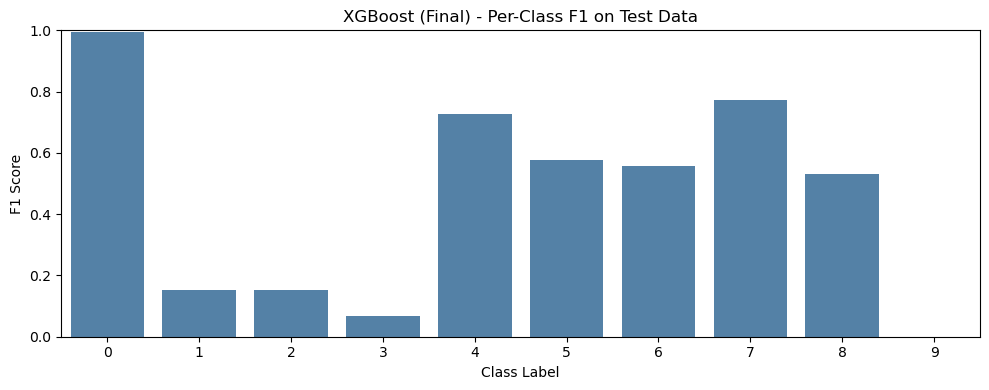

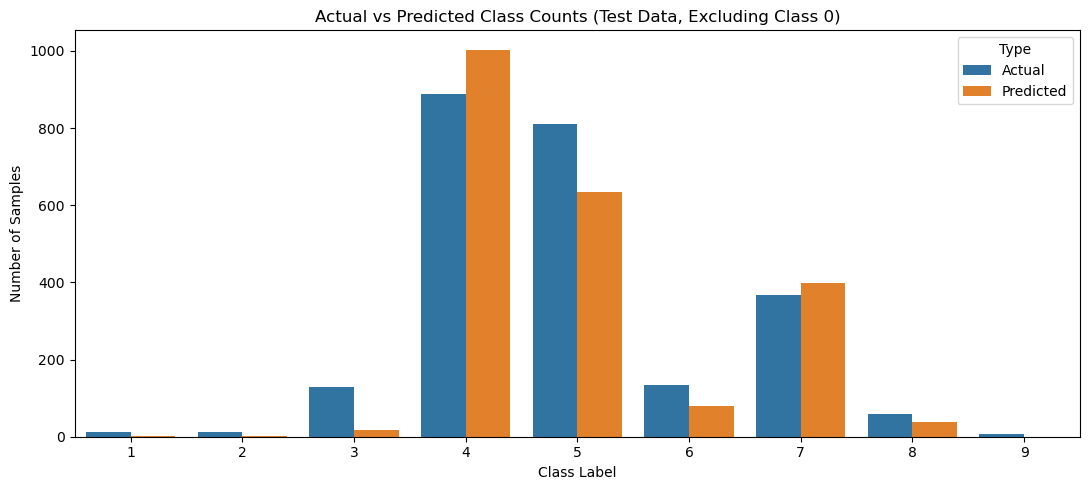

In [18]:
# Make an XGBoost model with the best params and evaluate on test set
xgb_best_params = {
    "colsample_bytree": 0.85,
    "gamma": 0.1,
    "learning_rate": 0.03,
    "max_depth": 6,
    "min_child_weight": 3,
    "n_estimators": 400,
    "subsample": 0.85,
}

xgb_final_model = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42,
    **xgb_best_params,
 )

xgb_final_model.fit(X_train, _squeeze_y(y_train))
xgb_final_results = evaluate_model(xgb_final_model, X_test, y_test, label="xgboost (final)")

print("\nFinal XGBoost Accuracy:", round(xgb_final_results["accuracy"], 4))

# Graph model ability on test data
report = xgb_final_results["classification_report"]
class_labels = [k for k in report.keys() if k not in ["accuracy", "macro avg", "weighted avg"]]
f1_scores = [report[k]["f1-score"] for k in class_labels]

plt.figure(figsize=(10, 4))
sns.barplot(x=class_labels, y=f1_scores, color="steelblue")
plt.title("XGBoost (Final) - Per-Class F1 on Test Data")
plt.xlabel("Class Label")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Actual vs guessed classes (test set)
y_true = _squeeze_y(y_test)
y_pred = xgb_final_model.predict(X_test)

comparison_df = pd.DataFrame({
    "Actual": pd.Series(y_true).astype(int),
    "Predicted": pd.Series(y_pred).astype(int),
})

actual_counts = comparison_df["Actual"].value_counts().sort_index()
pred_counts = comparison_df["Predicted"].value_counts().sort_index()
all_classes = sorted(set(actual_counts.index).union(set(pred_counts.index)))

plot_df = pd.DataFrame({
    "Class": all_classes,
    "Actual": [actual_counts.get(c, 0) for c in all_classes],
    "Predicted": [pred_counts.get(c, 0) for c in all_classes],
})

# Remove majority class 0 to reduce skew in visualization
plot_df = plot_df[plot_df["Class"] != 0]

plot_df_long = plot_df.melt(id_vars="Class", var_name="Type", value_name="Count")

plt.figure(figsize=(11, 5))
sns.barplot(data=plot_df_long, x="Class", y="Count", hue="Type")
plt.title("Actual vs Predicted Class Counts (Test Data, Excluding Class 0)")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

Evaluation: random_forest (final)
Accuracy: 0.9849
Confusion matrix:
 [[83219     3     0     6   101   402     6    28     6     0]
 [    5     1     0     0     5     0     0     0     0     0]
 [    4     0     2     1     3     2     0     0     0     0]
 [   18     0     0    15    80     3     4     8     0     0]
 [   68     0     1    18   714    15    17    52     4     0]
 [  220     0     1     5    37   542     1     4     0     0]
 [    8     0     0     9    40     4    70     0     1     1]
 [    0     0     0     3    57     4     1   303     0     0]
 [   26     0     0     1    14     0     0     0    19     0]
 [    0     0     0     0     7     0     0     0     0     0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     83771
           1       0.25      0.09      0.13        11
           2       0.50      0.17      0.25        12
           3       0.26      0.12      0.16       128
    

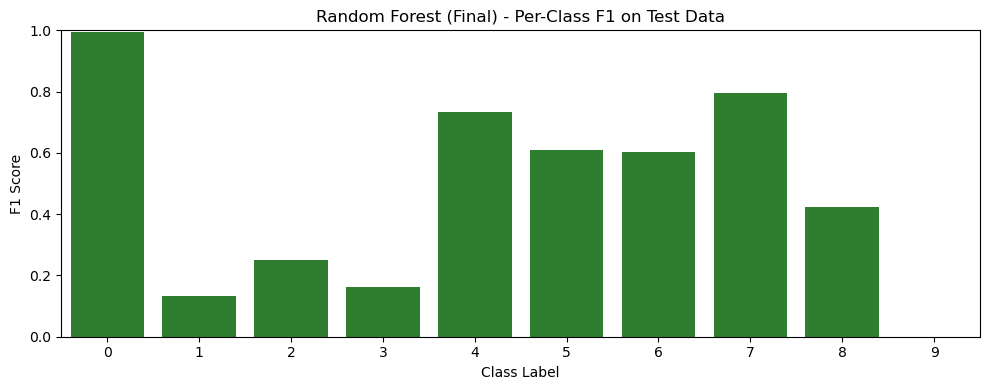

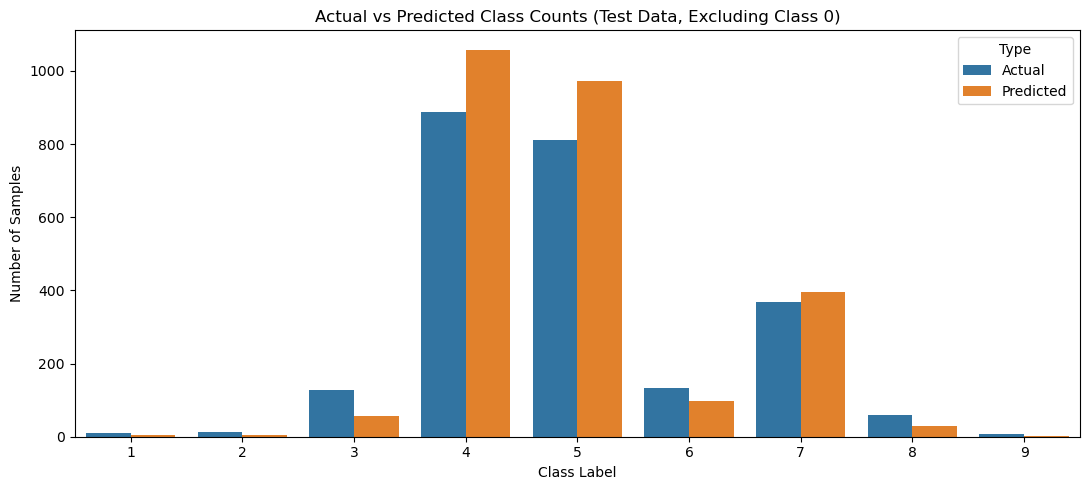

In [19]:
# Make a Random Forest model with the best params and evaluate on test set
rf_best_params = {
    "class_weight": "balanced",
    "max_depth": None,
    "max_features": None,
    "min_samples_leaf": 2,
    "min_samples_split": 5,
    "n_estimators": 200,
}

rf_final_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    **rf_best_params,
 )

rf_final_model.fit(X_train, _squeeze_y(y_train))
rf_final_results = evaluate_model(rf_final_model, X_test, y_test, label="random_forest (final)")

print("\nFinal Random Forest Accuracy:", round(rf_final_results["accuracy"], 4))

# Graph model ability on test data
rf_report = rf_final_results["classification_report"]
rf_class_labels = [k for k in rf_report.keys() if k not in ["accuracy", "macro avg", "weighted avg"]]
rf_f1_scores = [rf_report[k]["f1-score"] for k in rf_class_labels]

plt.figure(figsize=(10, 4))
sns.barplot(x=rf_class_labels, y=rf_f1_scores, color="forestgreen")
plt.title("Random Forest (Final) - Per-Class F1 on Test Data")
plt.xlabel("Class Label")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Actual vs guessed classes (test set)
rf_y_true = _squeeze_y(y_test)
rf_y_pred = rf_final_model.predict(X_test)

rf_comparison_df = pd.DataFrame({
    "Actual": pd.Series(rf_y_true).astype(int),
    "Predicted": pd.Series(rf_y_pred).astype(int),
})

rf_actual_counts = rf_comparison_df["Actual"].value_counts().sort_index()
rf_pred_counts = rf_comparison_df["Predicted"].value_counts().sort_index()
rf_all_classes = sorted(set(rf_actual_counts.index).union(set(rf_pred_counts.index)))

rf_plot_df = pd.DataFrame({
    "Class": rf_all_classes,
    "Actual": [rf_actual_counts.get(c, 0) for c in rf_all_classes],
    "Predicted": [rf_pred_counts.get(c, 0) for c in rf_all_classes],
})

# Remove majority class 0 to reduce skew in visualization
rf_plot_df = rf_plot_df[rf_plot_df["Class"] != 0]

rf_plot_df_long = rf_plot_df.melt(id_vars="Class", var_name="Type", value_name="Count")

plt.figure(figsize=(11, 5))
sns.barplot(data=rf_plot_df_long, x="Class", y="Count", hue="Type")
plt.title("Actual vs Predicted Class Counts (Test Data, Excluding Class 0)")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

Evaluation: gradient_boosting (final)
Accuracy: 0.9829
Confusion matrix:
 [[83495     2     8     4    86   141     7    20     8     0]
 [    5     0     0     0     5     0     1     0     0     0]
 [    7     0     1     0     4     0     0     0     0     0]
 [   39     0     1     2    77     3     1     2     2     1]
 [  186     1     2    10   646    10     5    25     3     1]
 [  497     2     2     1    42   259     1     4     0     2]
 [   51     0     0     0    45     7    25     1     1     3]
 [   24     0     1     0    67     0     0   276     0     0]
 [   43     0     0     0     3     1     0     1    12     0]
 [    1     0     0     0     3     0     0     0     0     3]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     83771
           1       0.00      0.00      0.00        11
           2       0.07      0.08      0.07        12
           3       0.12      0.02      0.03       128


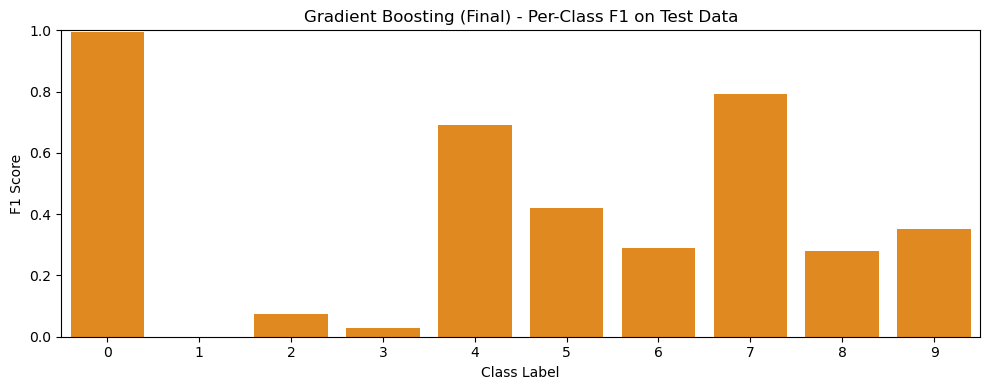

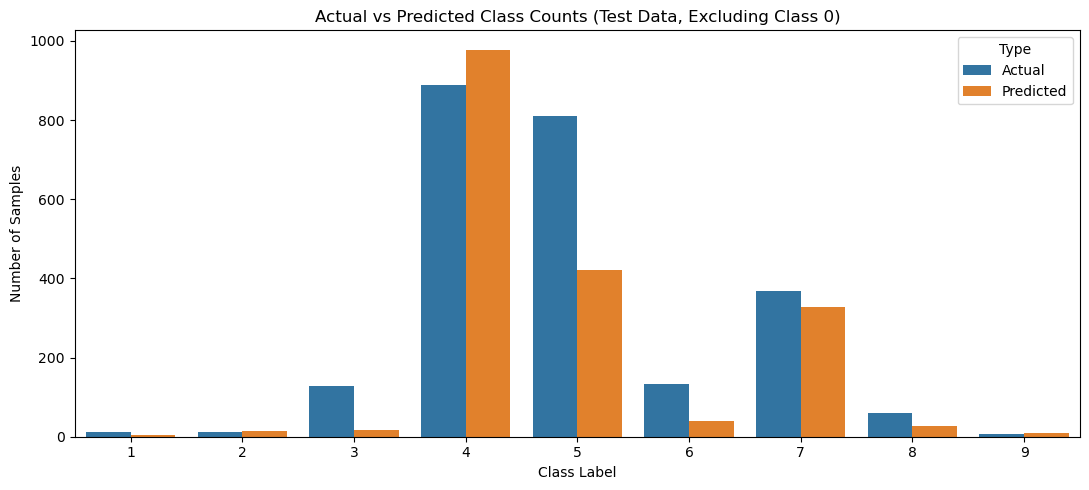

In [20]:
# Make a Gradient Boosting model with the best params and evaluate on test set
gb_best_params = {
    "learning_rate": 0.05,
    "max_depth": 3,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "n_estimators": 200,
    "subsample": 0.9,
}

gb_final_model = GradientBoostingClassifier(
    random_state=42,
    **gb_best_params,
 )

gb_final_model.fit(X_train, _squeeze_y(y_train))
gb_final_results = evaluate_model(gb_final_model, X_test, y_test, label="gradient_boosting (final)")

print("\nFinal Gradient Boosting Accuracy:", round(gb_final_results["accuracy"], 4))

# Graph model ability on test data
gb_report = gb_final_results["classification_report"]
gb_class_labels = [k for k in gb_report.keys() if k not in ["accuracy", "macro avg", "weighted avg"]]
gb_f1_scores = [gb_report[k]["f1-score"] for k in gb_class_labels]

plt.figure(figsize=(10, 4))
sns.barplot(x=gb_class_labels, y=gb_f1_scores, color="darkorange")
plt.title("Gradient Boosting (Final) - Per-Class F1 on Test Data")
plt.xlabel("Class Label")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Actual vs guessed classes (test set)
gb_y_true = _squeeze_y(y_test)
gb_y_pred = gb_final_model.predict(X_test)

gb_comparison_df = pd.DataFrame({
    "Actual": pd.Series(gb_y_true).astype(int),
    "Predicted": pd.Series(gb_y_pred).astype(int),
})

gb_actual_counts = gb_comparison_df["Actual"].value_counts().sort_index()
gb_pred_counts = gb_comparison_df["Predicted"].value_counts().sort_index()
gb_all_classes = sorted(set(gb_actual_counts.index).union(set(gb_pred_counts.index)))

gb_plot_df = pd.DataFrame({
    "Class": gb_all_classes,
    "Actual": [gb_actual_counts.get(c, 0) for c in gb_all_classes],
    "Predicted": [gb_pred_counts.get(c, 0) for c in gb_all_classes],
})

# Remove majority class 0 to reduce skew in visualization
gb_plot_df = gb_plot_df[gb_plot_df["Class"] != 0]

gb_plot_df_long = gb_plot_df.melt(id_vars="Class", var_name="Type", value_name="Count")

plt.figure(figsize=(11, 5))
sns.barplot(data=gb_plot_df_long, x="Class", y="Count", hue="Type")
plt.title("Actual vs Predicted Class Counts (Test Data, Excluding Class 0)")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

Evaluation: logistic (final)
Accuracy: 0.9664
Confusion matrix:
 [[83169     0     0     0    70   437    11    60    24     0]
 [   11     0     0     0     0     0     0     0     0     0]
 [   12     0     0     0     0     0     0     0     0     0]
 [  111     0     0     2     9     0     0     2     4     0]
 [  839     0     0     0    34     6     2     8     0     0]
 [  718     0     0     0    25    22     5    22    18     0]
 [  122     0     0     0     0     4     3     1     3     0]
 [  278     0     0     0     7     1     0    64    18     0]
 [   60     0     0     0     0     0     0     0     0     0]
 [    6     0     0     0     0     0     0     1     0     0]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     83771
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        12
           3       1.00      0.02      0.03       128
         

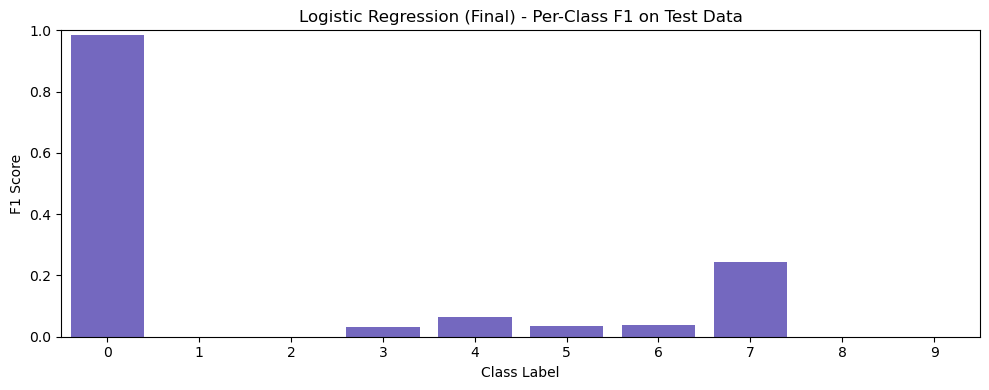

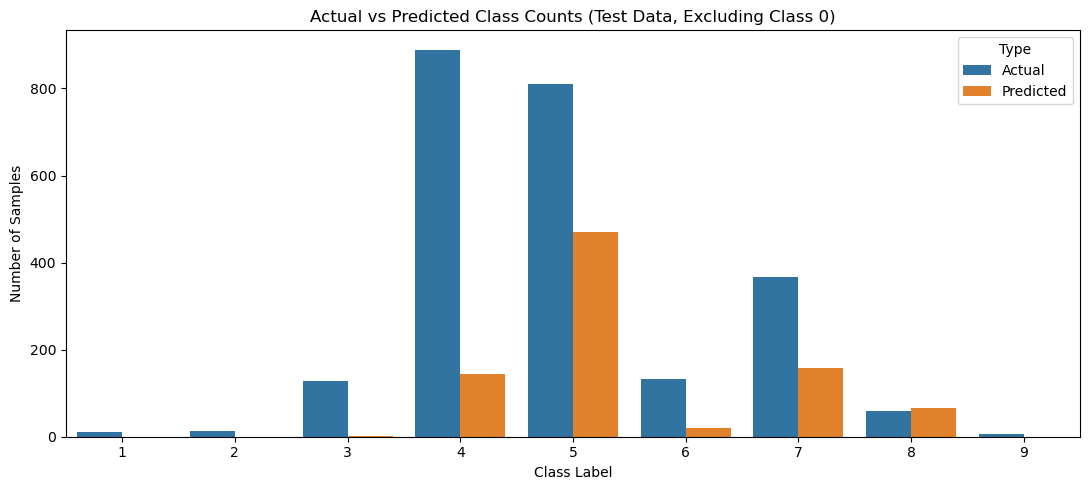

In [21]:
# Make a Logistic Regression model with the best params and evaluate on test set
lr_best_params = {
    "C": 0.01,
    "class_weight": None,
    "penalty": "l2",
    "solver": "lbfgs",
}

lr_final_model = LogisticRegression(
    max_iter=2000,
    random_state=42,
    **lr_best_params,
 )

lr_final_model.fit(X_train, _squeeze_y(y_train))
lr_final_results = evaluate_model(lr_final_model, X_test, y_test, label="logistic (final)")

print("\nFinal Logistic Regression Accuracy:", round(lr_final_results["accuracy"], 4))

# Graph model ability on test data
lr_report = lr_final_results["classification_report"]
lr_class_labels = [k for k in lr_report.keys() if k not in ["accuracy", "macro avg", "weighted avg"]]
lr_f1_scores = [lr_report[k]["f1-score"] for k in lr_class_labels]

plt.figure(figsize=(10, 4))
sns.barplot(x=lr_class_labels, y=lr_f1_scores, color="slateblue")
plt.title("Logistic Regression (Final) - Per-Class F1 on Test Data")
plt.xlabel("Class Label")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Actual vs guessed classes (test set)
lr_y_true = _squeeze_y(y_test)
lr_y_pred = lr_final_model.predict(X_test)

lr_comparison_df = pd.DataFrame({
    "Actual": pd.Series(lr_y_true).astype(int),
    "Predicted": pd.Series(lr_y_pred).astype(int),
})

lr_actual_counts = lr_comparison_df["Actual"].value_counts().sort_index()
lr_pred_counts = lr_comparison_df["Predicted"].value_counts().sort_index()
lr_all_classes = sorted(set(lr_actual_counts.index).union(set(lr_pred_counts.index)))

lr_plot_df = pd.DataFrame({
    "Class": lr_all_classes,
    "Actual": [lr_actual_counts.get(c, 0) for c in lr_all_classes],
    "Predicted": [lr_pred_counts.get(c, 0) for c in lr_all_classes],
})

# Remove majority class 0 to reduce skew in visualization
lr_plot_df = lr_plot_df[lr_plot_df["Class"] != 0]

lr_plot_df_long = lr_plot_df.melt(id_vars="Class", var_name="Type", value_name="Count")

plt.figure(figsize=(11, 5))
sns.barplot(data=lr_plot_df_long, x="Class", y="Count", hue="Type")
plt.title("Actual vs Predicted Class Counts (Test Data, Excluding Class 0)")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

Evaluation: lightgbm (final)
Accuracy: 0.9859
Confusion matrix:
 [[83432     2     0     3    60   244     5    21     4     0]
 [    7     1     0     0     3     0     0     0     0     0]
 [    7     0     1     0     4     0     0     0     0     0]
 [   28     0     0     9    75     6     4     6     0     0]
 [  105     0     0     9   693    22     9    48     3     0]
 [  308     0     0     2    31   462     3     4     0     0]
 [   20     0     0     3    41     5    62     0     1     1]
 [    7     0     0     1    60     6     0   294     0     0]
 [   30     0     0     1     5     0     1     0    23     0]
 [    0     0     0     0     6     1     0     0     0     0]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     83771
           1       0.33      0.09      0.14        11
           2       1.00      0.08      0.15        12
           3       0.32      0.07      0.12       128
         

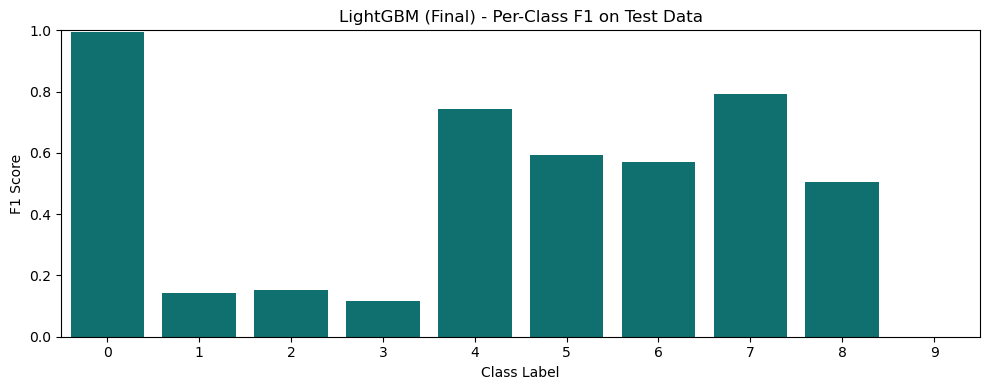

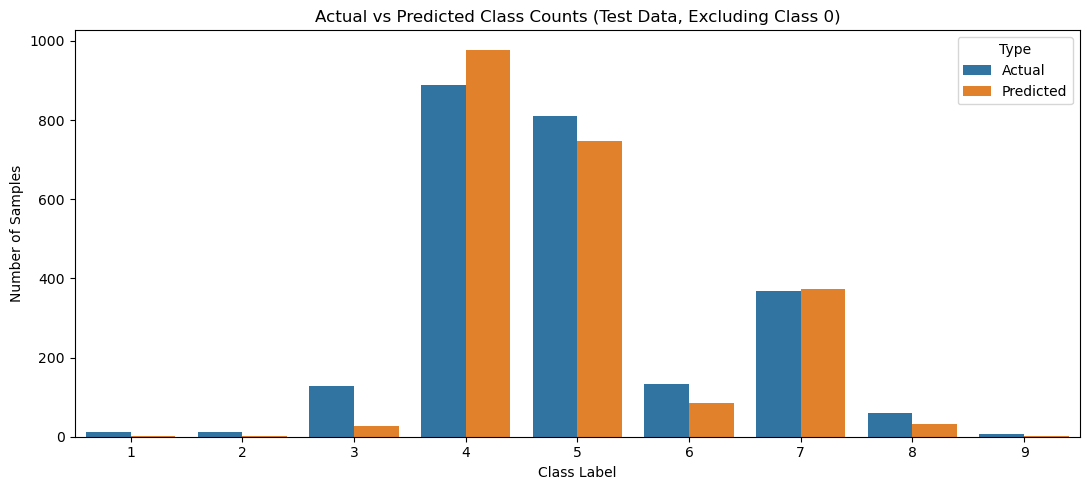

In [23]:
# Make a LightGBM model with the best params and evaluate on test set
lgbm_best_params = {
    "colsample_bytree": 0.7,
    "learning_rate": 0.03,
    "max_depth": 10,
    "min_child_samples": 40,
    "n_estimators": 200,
    "num_leaves": 31,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "subsample": 0.7,
}

lgbm_final_model = LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    verbosity=-1,
    **lgbm_best_params,
 )

lgbm_final_model.fit(X_train, _squeeze_y(y_train))
lgbm_final_results = evaluate_model(lgbm_final_model, X_test, y_test, label="lightgbm (final)")

print("\nFinal LightGBM Accuracy:", round(lgbm_final_results["accuracy"], 4))

# Graph model ability on test data
lgbm_report = lgbm_final_results["classification_report"]
lgbm_class_labels = [k for k in lgbm_report.keys() if k not in ["accuracy", "macro avg", "weighted avg"]]
lgbm_f1_scores = [lgbm_report[k]["f1-score"] for k in lgbm_class_labels]

plt.figure(figsize=(10, 4))
sns.barplot(x=lgbm_class_labels, y=lgbm_f1_scores, color="teal")
plt.title("LightGBM (Final) - Per-Class F1 on Test Data")
plt.xlabel("Class Label")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Actual vs guessed classes (test set)
lgbm_y_true = _squeeze_y(y_test)
lgbm_y_pred = lgbm_final_model.predict(X_test)

lgbm_comparison_df = pd.DataFrame({
    "Actual": pd.Series(lgbm_y_true).astype(int),
    "Predicted": pd.Series(lgbm_y_pred).astype(int),
})

lgbm_actual_counts = lgbm_comparison_df["Actual"].value_counts().sort_index()
lgbm_pred_counts = lgbm_comparison_df["Predicted"].value_counts().sort_index()
lgbm_all_classes = sorted(set(lgbm_actual_counts.index).union(set(lgbm_pred_counts.index)))

lgbm_plot_df = pd.DataFrame({
    "Class": lgbm_all_classes,
    "Actual": [lgbm_actual_counts.get(c, 0) for c in lgbm_all_classes],
    "Predicted": [lgbm_pred_counts.get(c, 0) for c in lgbm_all_classes],
})

# Remove majority class 0 to reduce skew in visualization
lgbm_plot_df = lgbm_plot_df[lgbm_plot_df["Class"] != 0]

lgbm_plot_df_long = lgbm_plot_df.melt(id_vars="Class", var_name="Type", value_name="Count")

plt.figure(figsize=(11, 5))
sns.barplot(data=lgbm_plot_df_long, x="Class", y="Count", hue="Type")
plt.title("Actual vs Predicted Class Counts (Test Data, Excluding Class 0)")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

### Final Findings Summary

- After comparing XGBoost, Random Forest, Gradient Boosting, Logistic Regression, and LightGBM, I am selecting **LightGBM** as the final model.
- LightGBM delivered top-tier overall accuracy on the test split while keeping strong performance on several minority attack classes.
- The class distribution is highly imbalanced, so class-level results were reviewed (not just total accuracy), including plots that exclude class `0` for clearer minority-class behavior.
- Final selected model: **LightGBM (final)** with tuned parameters from grid search.
- Next step: save the trained LightGBM model artifact for reuse in deployment/inference pipelines.

In [25]:
# Save final LightGBM model
import joblib

model_dir = "../models"
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, "lightgbm_final_model.pkl")
joblib.dump(lgbm_final_model, model_path)

print(f"LightGBM model saved to: {model_path}")

LightGBM model saved to: ../models\lightgbm_final_model.pkl
